# Part 1: from data to networks, using Python networkx

# I - Why studying social networks? Which areas/which questions to study?

- **To get a better understanding of people's behavior**
  - Our social networks influence our economic decisions, from what bank we use or stocks we invest in (e.g., Robinhood) 
    to which brands we buy (e.g., based on our friends' posts on Instagram, or Pages' recommendations on Facebook).
  - Networks may also trigger adverse reactions that need to be prevented, and therefore need to be monitored (e.g., the
    propagation of misinformation on social media and via online news) 
  - Recommended reading: [Using gossips to spread information](http://stanford.edu/~arungc/BCDJ_gossip.pdf)
    
    
- **To build new models and theories of social networks**
  - Networks evolve over time, and your connections are most likely to change as you move to another university or switch jobs. 
    There is ongoing research on the theory of dynamic social networks: how do they get formed? what makes them grow? can we 
    predict the size and shape of a network one or two years from now? 
  - This is an active area of research in complex systems and computer science, but also one where progress is made via empirical
    work in the field (e.g., experiments in the developing world in collaboration with local partners) or large-scale online 
    experiments such as the one Facebook and Microsoft have developed the infrastructure for.    
    Recommended reading: [Studying social networks in the developing world](https://www.gsb.stanford.edu/insights/studying-social-networks-developing-worlds-five-key-insights)   
    
- **To optimize for information diffusion or resource allocation**
  - Imagine we want to inform teenagers about HIV via prevention programs in homeless communities. It would be helpful to know or
    quickly learn about underlying friendship networks to best propagate the information.
  - Imagine we want to optimally distribute tests across cities in a province during an epidemic outbreak, under resource
    constraints (e.g., we have a limited number of kits to distribute) and as the infection is spreading. We would greatly 
    benefit from the knowledge of commuting flows and traffic between each locality!
  - Recommended reading: [Influence maximization with an uncertain network](https://dl.acm.org/doi/10.5555/3091125.3091306) 

# II - How do we go from data to networks?

Mathematically, $G = (\mathcal{N}, \mathcal{E})$. 

$\mathcal{N}$ denotes the set of nodes. Some may be isolated (i.e., they are not connected to any other node).

$\mathcal{E}$ denotes the set of edges (i.e., typically the most-left node is the individual the link is emerging "from", and the most-right node is the individual "to" whom the connection goes).

There are mainly two ways to store network-related information.

**Option 1:**
We often store networks as *tabular data*, e.g. 
- `nodes.csv` contains node ids and node attributes. 
- `edges.csv` contains ids of source and target node, plus edge attributes. 

**Option 2:**
We store an *edge list* (which is the repository of all existing connections), e.g., as a simple text file `edge_list.txt`.

**What is the main difference between these two options?**
- `nodes.csv` will usually contain information about all nodes, even those that are isolated, i.e., those that are not connected to any other nodes in the network.
- `edge_list.txt` is biased towards nodes that have at least one connection (so there is potentially one isolated part of the network that is not captured here).

**Our recitation today:**
Today, we will practice going from an *edge list* to a network object that we can actually study. 

# III - Data we will be using in this session

- Ego networks ("friends lists") from Facebook, for only 10 members. 
- We are working with only a subset of this large time-varying network.
- The full dataset, captured at a certain point in time, is accessible [on Stanford Network Analysis Project website](https://snap.stanford.edu/data/egonets-Facebook.html).

## 1) What type of data are we studying?

The networks discussed in this recitation are **“egocentric” networks**. 

- The term **“ego”** is used to denote a person connected to everyone in the network. 
- An ego network is the social world from **ego**'s point of view. 
- It is convention to use the term **“alter”** to refer to anyone else in the network. 
- This way, one can talk about both friends and followers or fans; it does not matter what role they play: from **ego's perspective**, they are all alters.

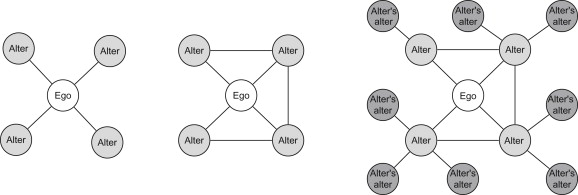

- On the left: **1.0 network** (basic knowledge: ego + their friends)
- In the middle: **1.5 network** (available knowledge: via Facebook API)
- On the right: **2.0 network** (ideal, but not readily available: would be possible via web-scraping for instance, but not made
  accessible via the API for the protection of the user's privacy)

## 2) Data characteristics - Let us get familar with the original source!



The data used in this recitation is from https://snap.stanford.edu/data/ego-Facebook.html. The data file     facebook_combined.txt is already included in the zip folder which contains this notebook.

You can download [facebook_combined.txt.gz](https://snap.stanford.edu/data/facebook_combined.txt.gz) --Edges from all egonets combined, from the bottom of the page, and decompress into .txt file. 


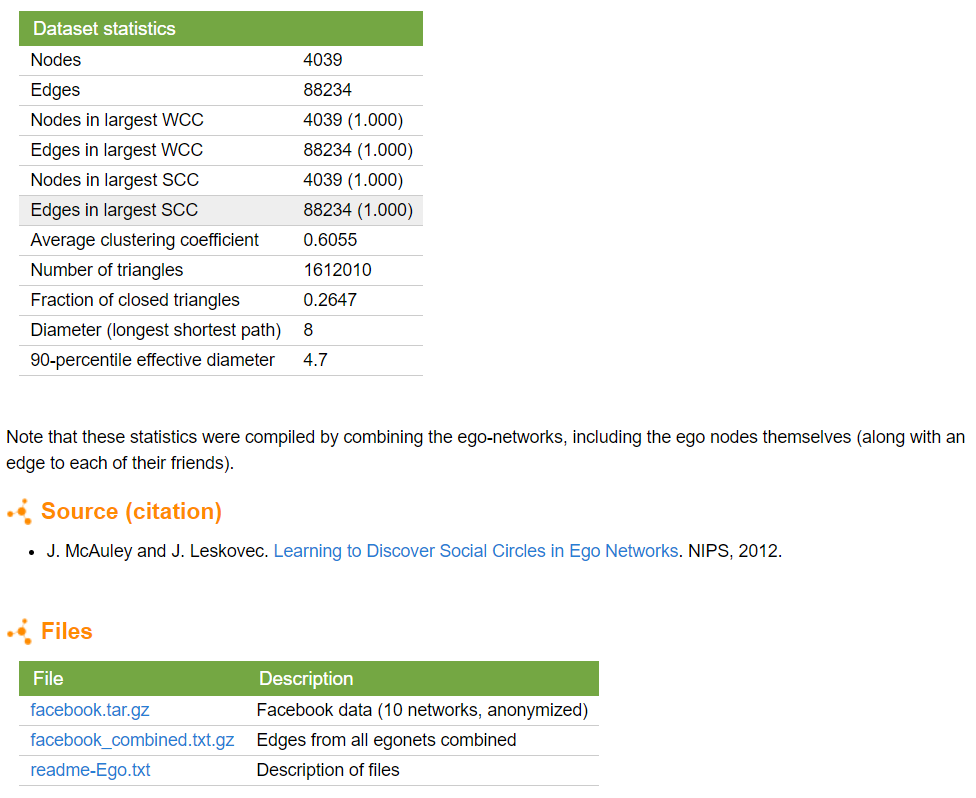

**Attribution:** The material below borrows from [this excellent blog post](https://blog.dominodatalab.com/social-network-analysis-with-networkx/), that we would recommend you to explore further after this session.

# IV - Exploratory Data Analysis (EDA)

## 1) Required Python packages

In [1]:
#!pip install networkx==2.0

In [2]:
import pandas as pd    # for reading and manipulating tabular data
import networkx as nx  # for constructing and studying networks
import numpy as np     # for arrays
#import community           # for community structure later
import collections          # for manipulation tuples and zipping objects
import statistics as stats  # for generating summary statistics
import time                 # for measuring computating time
from matplotlib import pyplot as plt  # for outputting nice plots
import seaborn as sns                 # for creating even nicer plots

get_ipython().magic(u'matplotlib inline')

In [3]:
print(nx.__version__)

2.5


## 2) Read and inspect the data

Sometimes we need to do more complex network construction. In this case our data is very simple. 

In [4]:
facebook_data_file = 'facebook_combined.txt'

# Create graph from edge list stored in data file
G = nx.read_edgelist(facebook_data_file,
                     create_using = nx.Graph(), # Use Graph() instead of DiGraph() for directed vs. undirected, 
                     nodetype = int) # Do not forget to specify node information type

## Let's inspect...

In [5]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


It's often useful to get these numbers programmatically; let's practice: 

In [6]:
G_nodes = G.nodes()
G_edges = G.edges()

print(type(G_nodes))
print(type(G_edges))

print(str(len(G_nodes)) + ' nodes, ' + str(len(G_edges)) + ' edges')

<class 'networkx.classes.reportviews.NodeView'>
<class 'networkx.classes.reportviews.EdgeView'>
4039 nodes, 88234 edges


Let us create a function that return this information for any graph, as we will often need it.

In [7]:
def graph_stats(graph):
    stats = 'Here is the composition of the graph: ' + str(len(graph.nodes())) + ' nodes, ' + str(len(graph.edges())) + ' edges'
    return(stats)

In [8]:
# Example with graph G that we have just created
graph_stats(G)

'Here is the composition of the graph: 4039 nodes, 88234 edges'

## 3) Accessing edge and node data

In [9]:
# We need to transform the node view into a list to manipulate the object.
G_nodes_list = list(G.nodes())
G_nodes_list[20:30] # for nxv2

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

In [10]:
# Show that the length of the node list matches the original length.
print('Length of transformed list: ', len(G_nodes_list))
print('Length of original list: ', len(G.nodes()))

Length of transformed list:  4039
Length of original list:  4039


In [11]:
# We need to transform the edge view into a list to manipulate the object.
G_edges_list = list(G.edges())
G_edges_list[1000:1030] # for nxv2

[(48, 54),
 (48, 57),
 (48, 73),
 (48, 80),
 (48, 88),
 (48, 119),
 (48, 126),
 (48, 130),
 (48, 180),
 (48, 199),
 (48, 203),
 (48, 271),
 (48, 299),
 (48, 302),
 (48, 320),
 (48, 322),
 (48, 330),
 (48, 332),
 (49, 192),
 (49, 241),
 (49, 255),
 (50, 109),
 (50, 113),
 (50, 119),
 (50, 146),
 (50, 148),
 (50, 203),
 (50, 277),
 (50, 314),
 (50, 331)]

In [12]:
# Show that the length of the edge list matches the original length.
print('Length of transformed list: ', len(G_edges_list))
print('Length of original list: ', len(G.edges()))

Length of transformed list:  88234
Length of original list:  88234


In [13]:
# Randomly pick a few edges in the object casted to a list to sanity check.
from random import randint

num_edges = 3
edge_indices = [randint(0, len(G_edges_list)) for i in range(num_edges)]

print('Indices: ', edge_indices)
random_edges = [G_edges_list[e] for e in edge_indices]
print('List of edges corresponding to these indices: ', random_edges)

Indices:  [3017, 80724, 12500]
List of edges corresponding to these indices:  [(136, 1932), (2334, 2348), (1010, 1529)]


# V - Exploratory Data Analysis

In [14]:
# Network metric statistics
def network_metric_statistics(metric_data):
    avg = stats.mean(metric_data)
    med = stats.median(metric_data)
    std = stats.stdev(metric_data)
    
    return("Here is a quick summary of your data: average = " + '{:.5f}'.format(avg) + ", median = " + '{:.5f}'.format(med) + ", standard deviation = " + '{:.5f}'.format(std))

In [15]:
# That is a generic function (you can apply it to any list---a metric of interest to you), and we will be looking at examples later on.
# We will first take a look at the degree distribution scenario.

In [16]:
# social ties
# levels of friendship / quantify friendship / identify Faceobook members 

## 1) Empirical Degree Distribution

In [17]:
print(type(G.degree))
print(G.degree[0])
# more complicated when each node is not an integer
# sanity check the degree of node 0 (easy to read from the edge list)

<class 'networkx.classes.reportviews.DegreeView'>
347


In [18]:
# Transform degree view into a list.
degree_sequence = sorted((G.degree[d] for d in range(len(G.degree))), reverse=True)  # for nx v2
print(type(degree_sequence))
print(degree_sequence[:5]) # from largest to smallest degree value

<class 'list'>
[1045, 792, 755, 547, 347]


In [19]:
network_metric_statistics(degree_sequence)

'Here is a quick summary of your data: average = 43.69101, median = 25.00000, standard deviation = 52.42061'

In [20]:
# degree distribution - meaning the number of edges of each node, using the network terminology

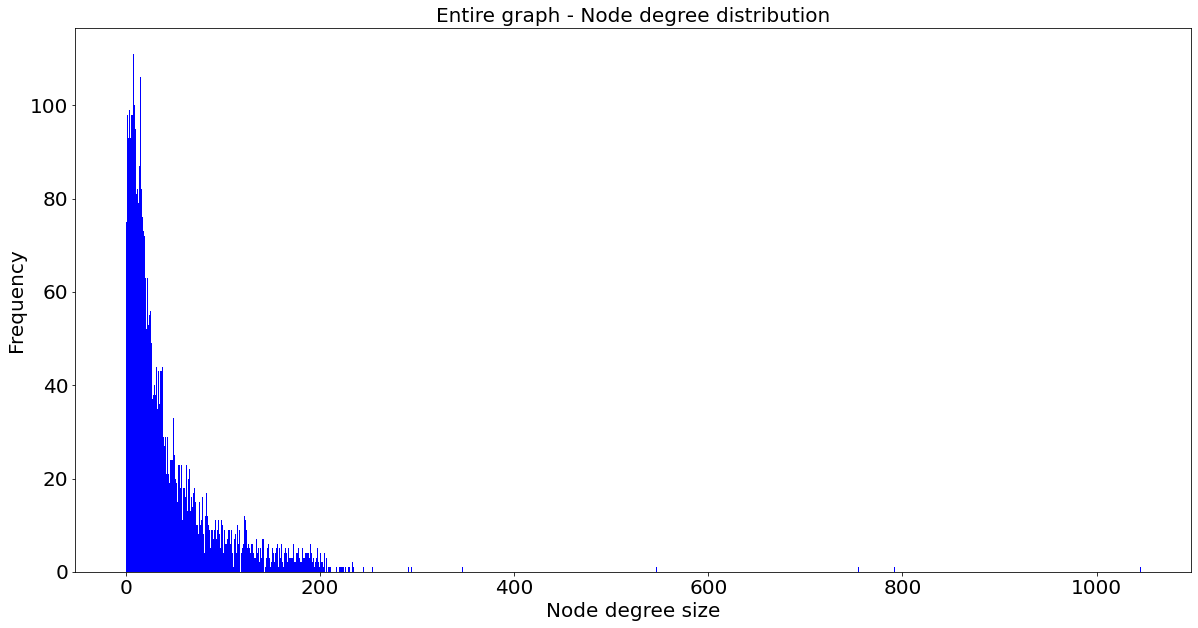

In [21]:
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

plt.figure(figsize=(20,10))

plt.bar(deg, cnt, width=1, color='b')
plt.xlabel("Node degree size", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Entire graph - Node degree distribution", fontsize=20)
plt.show()

# zoom on x-axis being around 900-1000

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


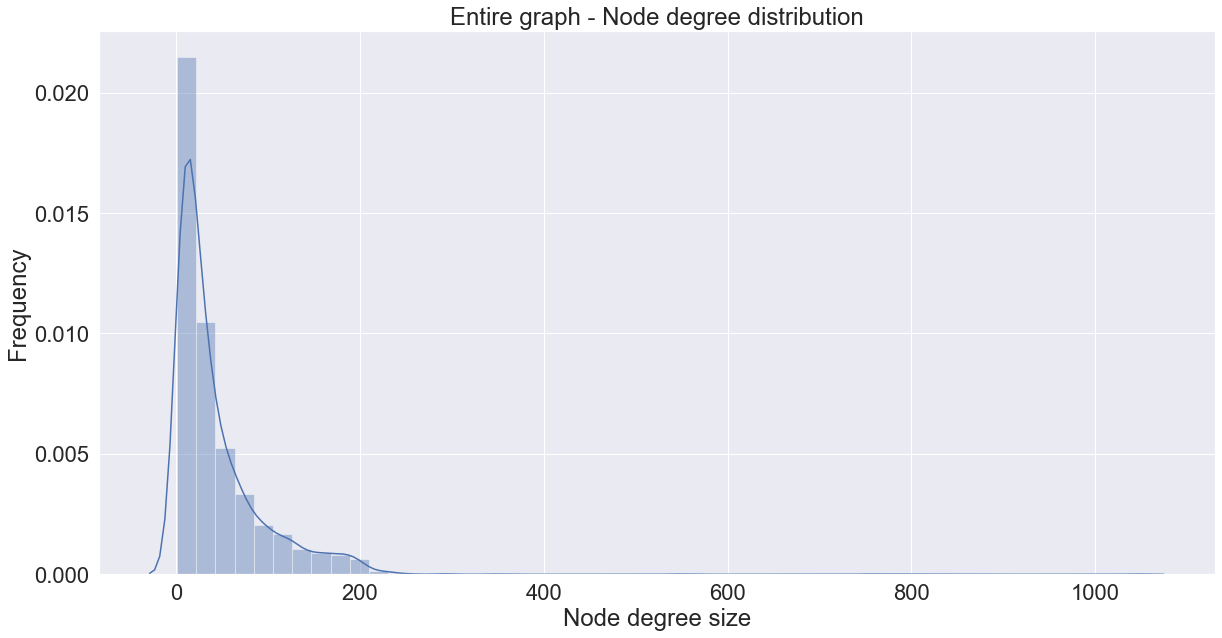

In [22]:
# for those who already know how to leverage existing tool, feel free to import seaborn as sns and show how to plot the histogram

plt.figure(figsize=(20,10))
sns.set(font_scale=2)
ax = sns.distplot(degree_sequence)
ax.set(xlabel="Node degree size",ylabel= "Frequency",title='Entire graph - Node degree distribution');
plt.show()

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
E:\Anaconda\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


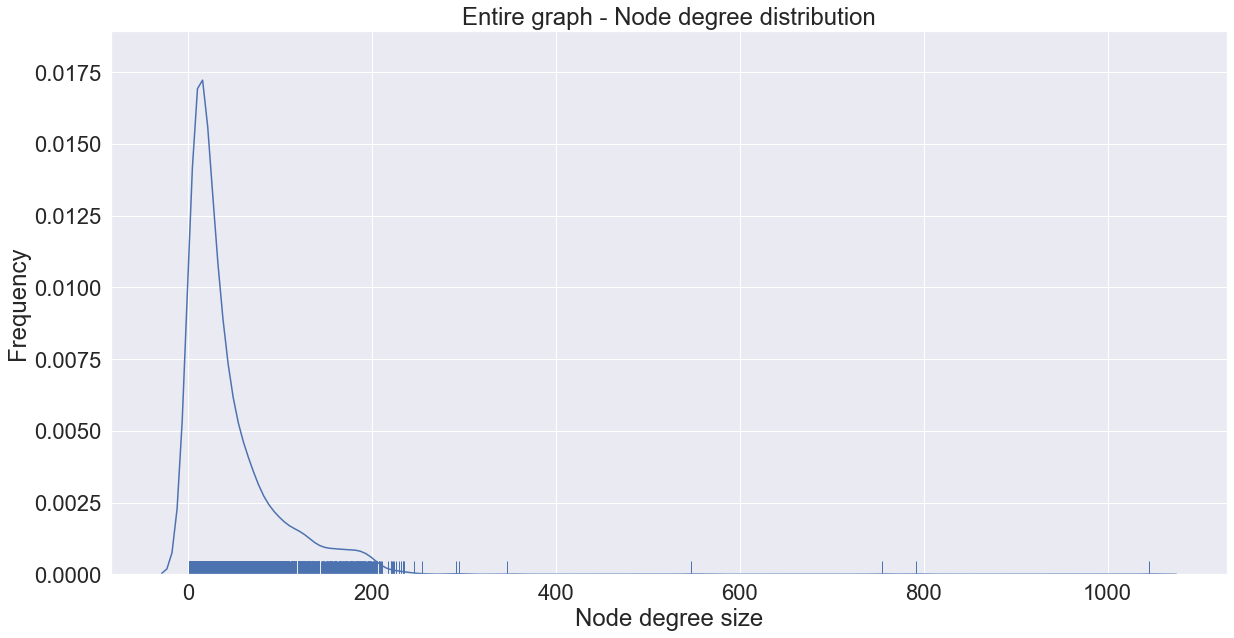

In [23]:
plt.figure(figsize=(20,10))
sns.set(font_scale=2)
ax = sns.distplot(degree_sequence, hist=False, rug=True)
ax.set(xlabel="Node degree size",ylabel= "Frequency",title='Entire graph - Node degree distribution');
plt.show()

## b) Review of power law distributions

**i) How do you recognize a power law distribution? What are some of its key characteristics?**

- Distribution is right skewed (as compared to normal distribution, e.g., height in the human populations)
- High ratio of max to min (as compared to normal distribution, e.g., tallest person vs. smallest person in the world)
- No matter what scale you look at it, it looks the same (i.e., the shape of the distribution is the same, to a multiplying       factor)

**ii) Discrete probability power law distribution, indexed by the degree value k (k greater than $k_{min})$**

$p(k) = \frac{\alpha-1}{k_{min}}.(\frac{k}{k_{min}})^{-\alpha}$

- $\alpha$ is the power in the **power law**
- $k_{min}$ is the minimum degree for which the **discrete probability law** applies

Let us take the logarithm on each side. What does that lead to?

For degree k greater than $k_{min}$:
$log(p(k)) = log(\frac{\alpha-1}{k_{min}}) - \alpha.log(\frac{k}{k_{min}})$

The above expression is linear in $log(\frac{k}{k_{min}})$.

**iii) Analogy with linear function: y = cx + b**

- $y = log(p(k))$
- $x = log(\frac{k}{k_{min}})$ 
- Intercept: $b = log(\frac{\alpha-1}{k_{min}})$
- Slope: $c = -\alpha$

*Note: while the distribution of the degree is a discrete distribution (recall: the degree of a node is integer-valued), we will be approximating it by a continuous distribution - to facilitate the calibration of the parameter $\alpha$.*



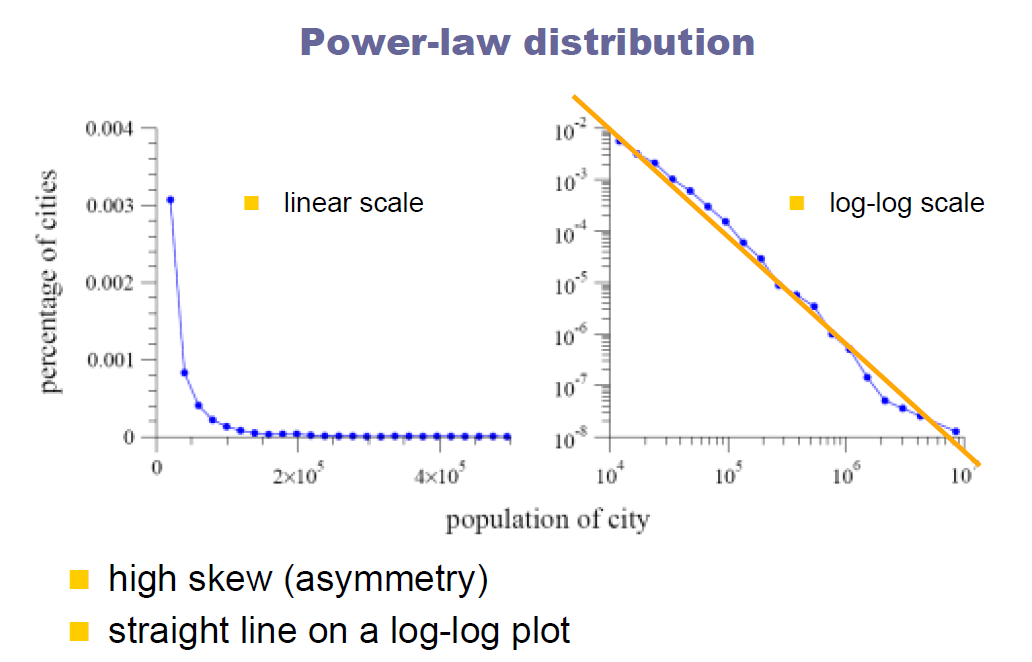
Attribution: Image modified from the paper [Power laws, Pareto distributions and Zipf’s law](https://arxiv.org/pdf/cond-mat/0412004.pdf), by M. E. J. Newman:

**iv) Why a power law? Why not an exponential distribution?**
- Many social networks are power laws. See this famous [Science paper](https://arxiv.org/pdf/cond-mat/9910332.pdf%3Forigin%3Dpublication_detail) from Reka Albert and Albert-Laszlo Barabasi.
- For a social network, there would not be any interpretation of the half-time, which is often used in physics and in operations   management.
- For an exponential distribution, a stricter assumption is made.

**v) How prominent is this in nature?**
- What characteristics of social networks are also present in other networks, which make them exhibit a power law distribution?
- How to decide that I should fit a power law? What are the characteristics, similar to a social network, that would help me determine that this is the right underlying model?
- Other examples: energy networks, transportation networks etc. (e.g., tree structure, importance of hierarchy)

For example, below are cumulative distributions or “rank/frequency plots” of twelve quantities reputed to follow power laws, taken from the paper [Power laws, Pareto distributions and Zipf’s law](https://arxiv.org/pdf/cond-mat/0412004.pdf), by M. E. J. Newman:

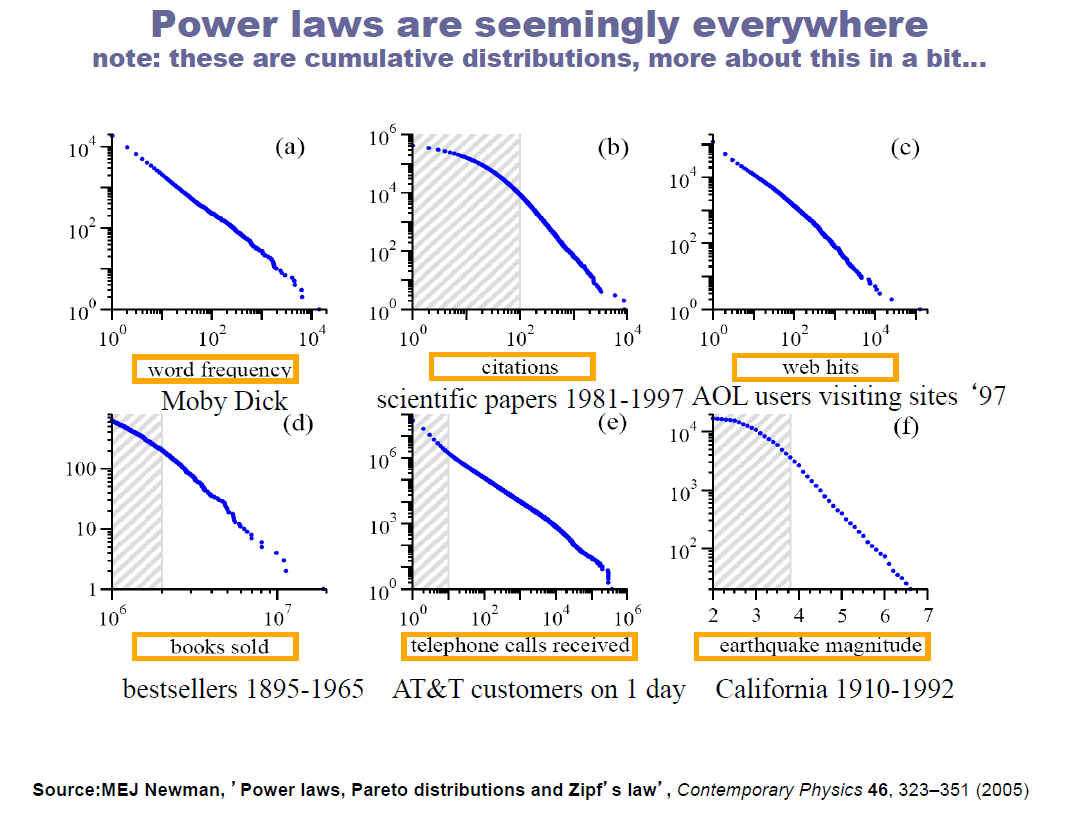


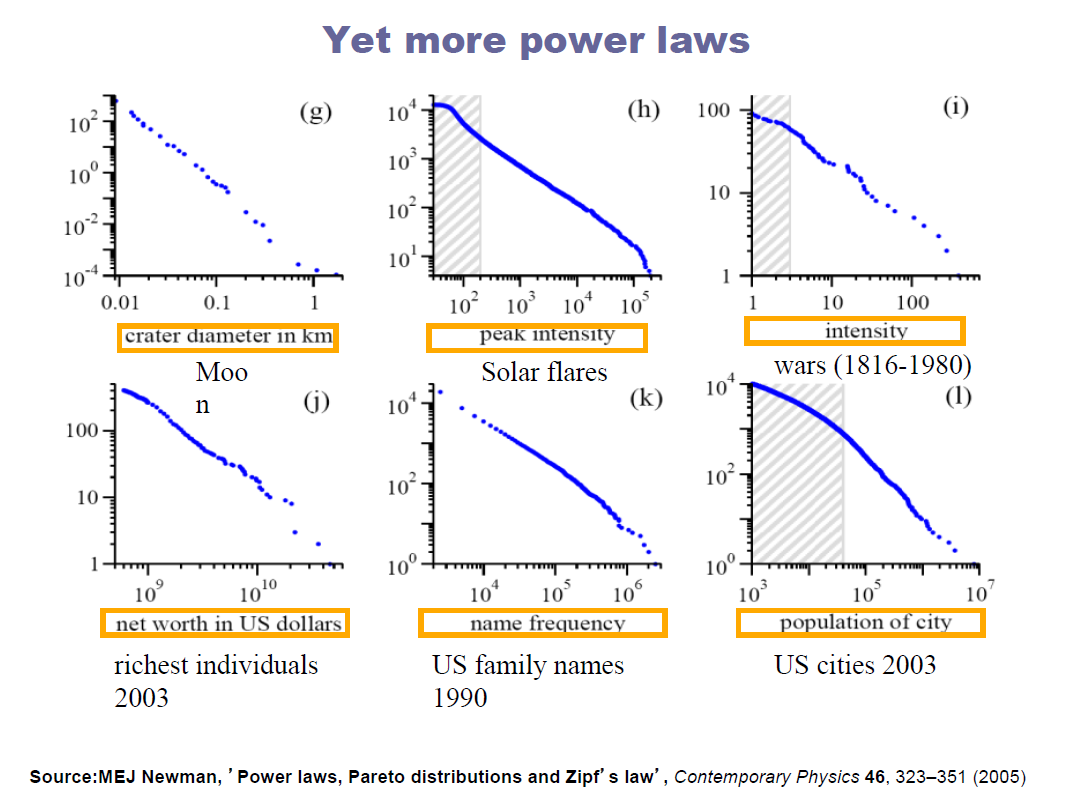


## 3) Application: fitting a power law distribution (simple version)

### a) Standard analysis

In [24]:
# Try both 
# Overlay the two distributions - with different parameters in the notebook (for loop on lambda decay values)

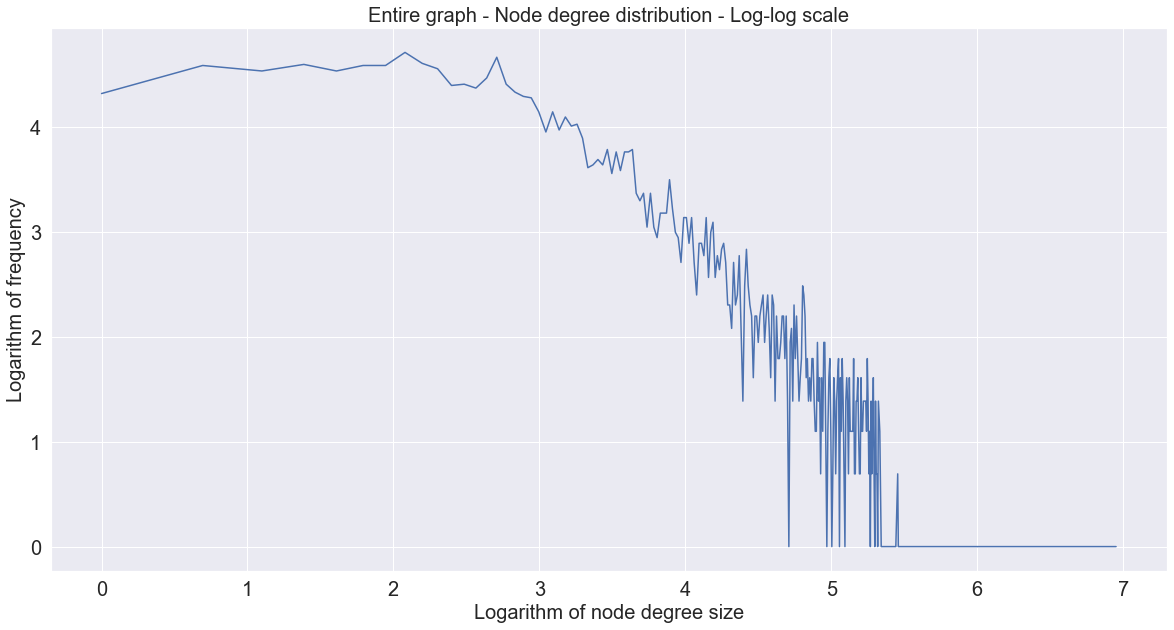

In [25]:
# it should look linear on a log-log scale

log_deg = np.log(deg)
log_cnt = np.log(cnt)

plt.figure(figsize=(20,10))

plt.plot(log_deg, log_cnt, color='b')
plt.xlabel('Logarithm of node degree size', fontsize=20)
plt.ylabel('Logarithm of frequency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Entire graph - Node degree distribution - Log-log scale", fontsize=20)
plt.show()

In [26]:
print(type(cnt))

<class 'tuple'>


In [27]:
cnt_list = list(cnt)

# Scaling factor
division_factor = sum(cnt_list[:-1]) # remove degree = 1
cnt_proba_list = [cnt_list[i]/division_factor for i in range(len(cnt_list)-1)] # remove degree = 1

In [28]:
# Sanity check
print(len(cnt_list))
print(len(cnt_proba_list))

227
226


In [29]:
from sklearn import linear_model

lm = linear_model.LinearRegression()

deg_list = list(deg)[:-1]
kmin = 2
log_deg_list = [np.log(deg_list[i]/kmin) for i in range(len(deg_list))]
log_cnt_proba_list = [np.log(e) for e in cnt_proba_list]
# Set up the matrix x (no need to create a column of 1's - the intercept is automatically considered when fitting the regression)
X = pd.DataFrame({'log_deg': log_deg_list}, columns=['log_deg'])

# Linear regression model
model = lm.fit(X, log_cnt_proba_list)

In [30]:
# Check the slope c
c = model.coef_[0]
print('Slope c: ', c)
# Deduce the value of alpha
alpha = -c
print('Exponent alpha: ', alpha)

Slope c:  -1.244820113441891
Exponent alpha:  1.244820113441891


In [31]:
# Check the intercept b
b = model.intercept_
print('Intercept b: ', b)
# Check whether it deviates from its theoretical value: log(alpha-1/kmin)
theoretical_b = np.log((alpha-1)/kmin)
print('Theoretical b, using the estimated value for alpha: ', theoretical_b)
print('% absolute error: ', np.round((-b+theoretical_b)/theoretical_b*100,1))

Intercept b:  -1.5324561967970896
Theoretical b, using the estimated value for alpha:  -2.1003787495262625
% absolute error:  27.0


In [32]:
from scipy.optimize import curve_fit

def exponential_func(x, a):
    return a*np.exp(-a*x)

popt, pcov = curve_fit(exponential_func, deg_list, cnt_proba_list, p0=(1))

In [33]:
popt[0]

2.142431190519157

In [34]:
# Mean absolute error - Overall
print(deg_list)
predictions_expo = [popt[0] * np.exp(-popt[0]*e) for e in deg_list]
predictions_expo = np.array(predictions_expo)
print(sum(predictions_expo))
print(predictions_expo[190:])
print((abs(predictions_expo/sum(predictions_expo) - cnt_proba_list)).mean())

[1045, 792, 755, 547, 347, 294, 291, 254, 245, 235, 234, 231, 229, 226, 224, 223, 222, 221, 220, 217, 211, 210, 209, 207, 205, 204, 203, 202, 201, 200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10

### b) Goodness of fit

In [35]:
predictions = lm.predict(X)

In [36]:
print(np.exp(predictions[:10]))# show the non log version
print(cnt_proba_list[:10])

[8.93170232e-05 1.26124516e-04 1.33864270e-04 1.99935185e-04
 3.52320325e-04 4.33054464e-04 4.38618932e-04 5.19523914e-04
 5.43386603e-04 5.72318729e-04]
[0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463]


In [37]:
sum(np.exp(predictions))

1.3254948905886563

In [38]:
# Magnitude of the prediction error for small values of k
print(np.exp(predictions)[200:210])
print(cnt_proba_list[200:210])
print((abs(np.exp(predictions)[200:210] - cnt_proba_list[200:210])).mean())

# Magnitude of the prediction error for large values of k
print(np.exp(predictions)[:10])
print(cnt_proba_list[:10])
print((abs(np.exp(predictions)[:10] - cnt_proba_list[:10])).mean())

# Mean absolute error - Overall
sum_predictions = sum(np.exp(predictions))
print(sum_predictions)
print((abs(np.exp(predictions)/sum_predictions - cnt_proba_list)).mean())

[0.00846059 0.00886755 0.00931123 0.00979662 0.01032963 0.01091732
 0.0115682  0.01229257 0.01310306 0.0140153 ]
[0.01236125126135217, 0.014127144298688193, 0.013874873864783047, 0.015136226034308779, 0.013370332996972755, 0.015893037336024218, 0.013118062563067608, 0.015893037336024218, 0.018163471241170535, 0.018415741675075682]
0.004169111092229629
[8.93170232e-05 1.26124516e-04 1.33864270e-04 1.99935185e-04
 3.52320325e-04 4.33054464e-04 4.38618932e-04 5.19523914e-04
 5.43386603e-04 5.72318729e-04]
[0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463, 0.0002522704339051463]
0.00018054411054577166
1.3254948905886563
0.002859146445052765


226
226


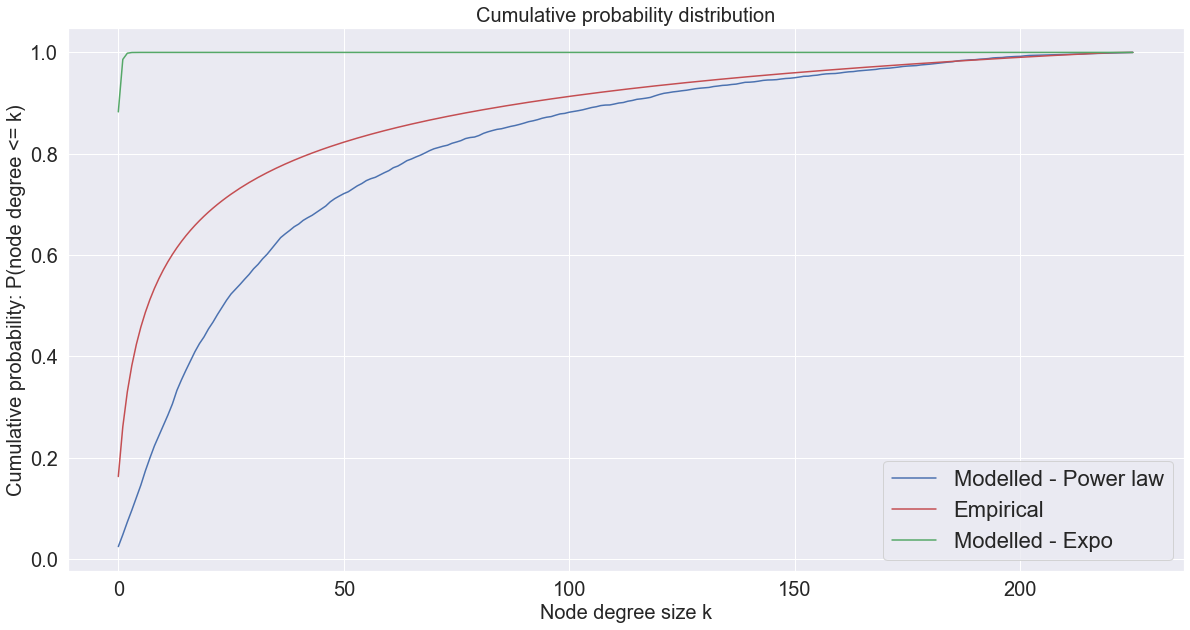

In [39]:
predictions_reverse = np.exp(predictions)[::-1]/sum_predictions
predictions_cumsum = pd.Series(predictions_reverse)   
cumsum = predictions_cumsum.cumsum()
#print(cumsum)
print(len(cumsum))

predictions_expo_reverse = predictions_expo[::-1]/sum(predictions_expo)
predictions_expo_cumsum = pd.Series(predictions_expo_reverse)
expo_cumsum = predictions_expo_cumsum.cumsum()

cnt_proba_list_reverse = cnt_proba_list[::-1]
cnt_proba_list_cumsum = pd.Series(cnt_proba_list_reverse)
cnt_cumsum = cnt_proba_list_cumsum.cumsum()
#print(cnt_cumsum)
print(len(cnt_cumsum))

plt.figure(figsize=(20,10))

plt.plot(cnt_cumsum, color='b', label='Modelled - Power law')
plt.plot(cumsum, color='r', label='Empirical')
plt.plot(expo_cumsum, color='g', label='Modelled - Expo')
plt.xlabel('Node degree size k', fontsize=20)
plt.ylabel('Cumulative probability: P(node degree <= k)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Cumulative probability distribution", fontsize=20)
leg=plt.legend()
plt.show()

### c) Modeling without outliers

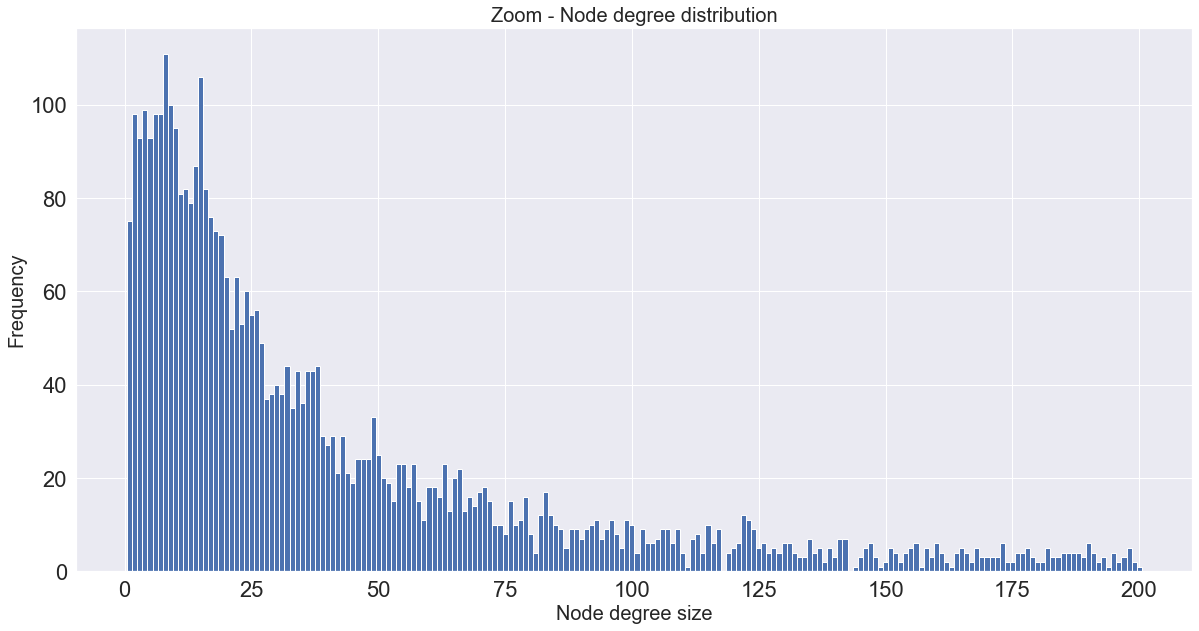

In [40]:
# let us do analysis without the outliers, i.e., for degree k <= 200 (right truncation)
degree_upper_bound = 200
restricted_degree_sequence = [degree_sequence[i] for i in range(len(degree_sequence)) if degree_sequence[i] <= degree_upper_bound]

restricted_degree_count = collections.Counter(restricted_degree_sequence)
restricted_deg, restricted_cnt = zip(*restricted_degree_count.items())

plt.figure(figsize=(20,10))

plt.bar(restricted_deg, restricted_cnt, width=1, color='b')
plt.xlabel("Node degree size", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.title("Zoom - Node degree distribution", fontsize=20)
plt.show()

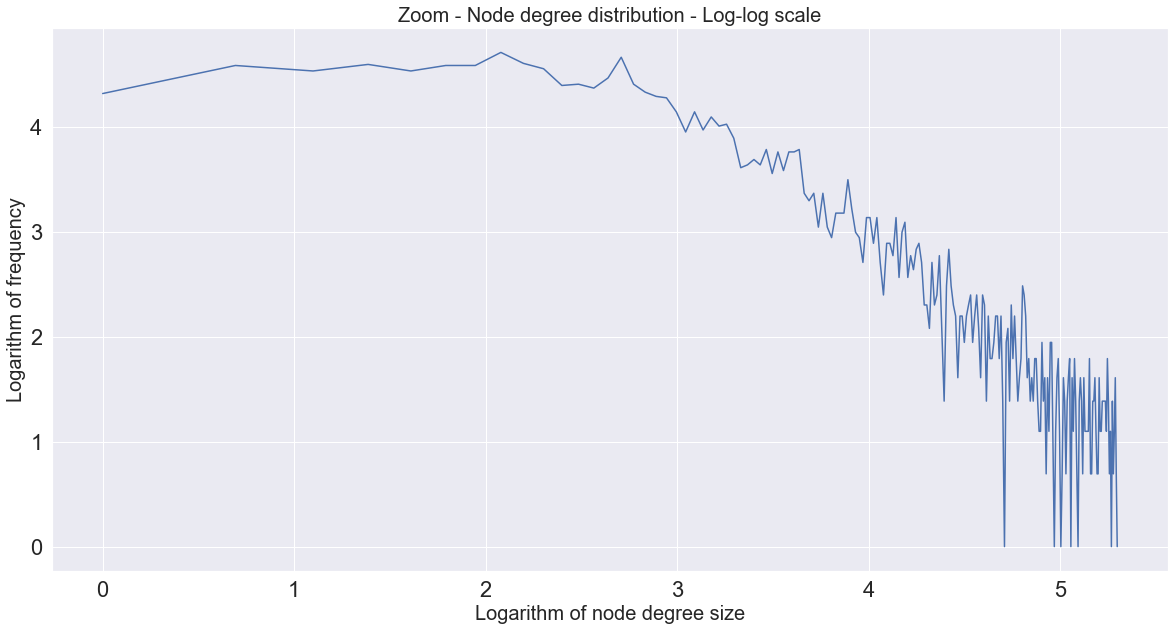

In [41]:
restricted_log_deg = np.log(restricted_deg)
restricted_log_cnt = np.log(restricted_cnt)

plt.figure(figsize=(20,10))

plt.plot(restricted_log_deg, restricted_log_cnt, color='b')
plt.xlabel('Logarithm of node degree size', fontsize=20)
plt.ylabel('Logarithm of frequency', fontsize=20)
plt.title("Zoom - Node degree distribution - Log-log scale", fontsize=20)
plt.show()

In [42]:
restricted_cnt_list = list(restricted_cnt)

# Scaling factor
restricted_division_factor = sum(restricted_cnt_list) # remove degree = 1
restricted_cnt_proba_list = [restricted_cnt_list[i]/restricted_division_factor for i in range(len(restricted_cnt_list))] # remove degree = 1

In [43]:
restricted_lm = linear_model.LinearRegression()

restricted_deg_list = list(restricted_deg)
kmin = 2
log_restricted_deg_list = [np.log(restricted_deg_list[i]/kmin) for i in range(len(restricted_deg_list))]
log_restricted_cnt_proba_list = [np.log(e) for e in restricted_cnt_proba_list]
# Set up the matrix x (no need to create a column of 1's - the intercept is automatically considered when fitting the regression)
restricted_X = pd.DataFrame({'log_restricted_deg': log_restricted_deg_list}, columns=['log_restricted_deg'])

# Linear regression model
restricted_model = restricted_lm.fit(restricted_X, log_restricted_cnt_proba_list)

In [44]:
print(restricted_lm.score(restricted_X, log_restricted_cnt_proba_list))

0.7969328764502489


In [45]:
# Check the slope
print('Slope, using restricted degree range: ', restricted_model.coef_[0])
print('Slope, using unrestricted degree range: ', model.coef_[0])

print('Absolute percentage difference in slope: ', round(-abs(restricted_model.coef_[0]-model.coef_[0])/model.coef_[0]*100,1))

Slope, using restricted degree range:  -1.105170853439412
Slope, using unrestricted degree range:  -1.244820113441891
Absolute percentage difference in slope:  11.2


In [46]:
# Check the intercept
print('Intercept, using restricted degree range: ', restricted_model.intercept_)
print('Intercept, using unrestricted degree range: ', model.intercept_)

print('Absolute percentage difference in intercept: ', round(-abs(restricted_model.intercept_-model.intercept_)/model.intercept_*100,1))

Intercept, using restricted degree range:  -1.9984156474008454
Intercept, using unrestricted degree range:  -1.5324561967970896
Absolute percentage difference in intercept:  30.4


In [47]:
# one model with kmax
# which model do I prefer? one is giving better fit, but more complicated
# is that changing the key parameter (alpha)? 
# what is the difference between the two estimates?
# what will prompt me to choose one model or another? (kmax - would introduce another parameter, I would need another model to represent 
# the world between kmax and infinity: between 200 and 1045 I don't many points )
# if there was a huge difference, I would have opted for kmax and kmin, but not tried to model kmax infinity because not enough data
# trained - 
# chosen the model R2 on valid
# test set of egonetworks
# do you have more data? otherwise, go with the simplest model / more parsimonious - so more robust to outliers 

In [48]:
restricted_predictions = restricted_lm.predict(restricted_X)

print(np.exp(restricted_predictions[:10]))# show the non log version
print(restricted_cnt_proba_list[:10])

[0.00083514 0.00083978 0.00084446 0.0008492  0.00085399 0.00085883
 0.00086373 0.00086868 0.00087368 0.00087873]
[0.00025006251562890725, 0.0005001250312578145, 0.001250312578144536, 0.0007501875468867217, 0.0005001250312578145, 0.001000250062515629, 0.00025006251562890725, 0.0007501875468867217, 0.0005001250312578145, 0.001000250062515629]


In [49]:
# Magnitude of the prediction error for small values of k
print(np.exp(restricted_predictions)[190:])
print(restricted_cnt_proba_list[190:])
print((abs(np.exp(restricted_predictions)[190:] - restricted_cnt_proba_list[190:])).mean())

# Magnitude of the prediction error for large values of k
print(np.exp(restricted_predictions)[:10])
print(restricted_cnt_proba_list[:10])
print((abs(np.exp(restricted_predictions)[:10] - restricted_cnt_proba_list[:10])).mean())

# Mean absolute error - Overall
print((abs(np.exp(restricted_predictions) - restricted_cnt_proba_list)).mean())

[0.02929004 0.03394775 0.04025303 0.04923879 0.06301001 0.08659408
 0.13554987 0.29160079]
[0.0277569392348087, 0.024506126531632907, 0.024506126531632907, 0.023255813953488372, 0.024756189047261814, 0.023255813953488372, 0.024506126531632907, 0.018754688672168042]
0.06727331648115557
[0.00083514 0.00083978 0.00084446 0.0008492  0.00085399 0.00085883
 0.00086373 0.00086868 0.00087368 0.00087873]
[0.00025006251562890725, 0.0005001250312578145, 0.001250312578144536, 0.0007501875468867217, 0.0005001250312578145, 0.001000250062515629, 0.00025006251562890725, 0.0007501875468867217, 0.0005001250312578145, 0.001000250062515629]
0.00031520930785779546
0.003931862804206972


In [50]:
# truncated the graph - 2 regimes
# power alpha candidate

In [51]:
# Twitter data
# followers, retweets
# Look at what makes the most sense/is the most tangible

# citation network exercise in the homework - (hubs, authorities)
# degree is maybe not only the indicator

# first order neighborhood level/ transportation (how much of a hub an airport - connections)
# but maybe in biological networks you are interested in higher order neighborhood (because indirect connections play a role)
# but for some applications the second order info does not even matter

# motivation: importance of a node, rely on degree -- 
# How do I know that ppl pointing to me are important? 
# directionality - learn more

# VI - Directed networks/graphs

In [52]:
# In order to look at in- and out-degree separately, we first need to construct a directed graph.
twitter_data_file = 'twitter_combined.txt'

directed_G = nx.read_edgelist(twitter_data_file,
                     create_using = nx.DiGraph(), 
                     nodetype = int)

FileNotFoundError: [Errno 2] No such file or directory: 'twitter_combined.txt'

In [ ]:
directed_G_nodes = list(directed_G.nodes)
directed_G_in_degree = list(dict(directed_G.in_degree(directed_G_nodes)).values())

In [ ]:
in_degree_sequence = sorted((directed_G_in_degree[d] for d in range(len(directed_G.in_degree))), reverse=True)  # degree sequence for nx v2
network_metric_statistics(in_degree_sequence)

In [ ]:
in_degree_count = collections.Counter(in_degree_sequence)
in_deg, in_cnt = zip(*in_degree_count.items())

plt.figure(figsize=(20,10))

plt.bar(in_deg, in_cnt, width=1, color='r')
plt.xlabel("Node in-degree size", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.title("Entire graph - Node in-degree distribution", fontsize=20)
plt.show()

In [ ]:
directed_G_out_degree = list(dict(directed_G.out_degree(directed_G_nodes)).values())

In [ ]:
out_degree_sequence = sorted((directed_G_out_degree[d] for d in range(len(directed_G.out_degree))), reverse=True)  # degree sequence for nx v2
network_metric_statistics(out_degree_sequence)

In [ ]:
out_degree_count = collections.Counter(out_degree_sequence)
out_deg, out_cnt = zip(*out_degree_count.items())

plt.figure(figsize=(20,10))

plt.bar(out_deg, out_cnt, width=1, color='g')
plt.xlabel("Node out-degree size")
plt.ylabel("Frequency")
plt.title("Entire graph - Node out-degree distribution")
plt.show()

In [ ]:
out_degree_upper_bound = 250
restricted_out_degree_sequence = [out_degree_sequence[i] for i in range(len(out_degree_sequence)) if out_degree_sequence[i] <= out_degree_upper_bound]  # degree sequence for nx v2
restricted_out_degree_count = collections.Counter(restricted_out_degree_sequence)
restricted_out_deg, restricted_out_cnt = zip(*restricted_out_degree_count.items())

plt.figure(figsize=(20,10))

plt.bar(restricted_out_deg, restricted_out_cnt, width=1, color='g')
plt.xlabel("Node out-degree size")
plt.ylabel("Frequency")
plt.title("Zoom - Node out-degree distribution")
plt.show()

In [ ]:
# larger variance in out-degree - following activity (I follow a lot of people)
# motivation: behavior that we want to check in the data (mention at the beginning)

# VII - Visualization

In [ ]:
# switch that to the sanity check portion of the recitation
print(nx.is_connected(G))
print(nx.number_connected_components(G))
print(nx.is_bipartite(G))
print(list(nx.find_cycle(G, orientation='ignore')))

In [ ]:
#Active learning: get the diameter, clustering coefficient (link to a page)
# modularity, density, etc. 
# get familiarized with these metrics before we go to the centrlaty recitation

## 1) Network Layout

People make their careers inventing layout algorithms! We'll choose a simple one. 

In [ ]:
t = time.time()
spring_pos = nx.spring_layout(G) # might take a little while
elapsed = time.time() - t
print('Time elapsed to get the graph layout: ', elapsed)

## 2) Basic plotting

In [ ]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
ax.axis('off')

node_size_default = 40

n = nx.draw_networkx(G, 
                     spring_pos,
                     ax = ax,
                     node_size = node_size_default,
                     with_labels = False)
plt.title("Entire graph - Default node size")
plt.close();

# How does it look?...

In [ ]:
fig

## 3) Taking into account node sizes

In [ ]:
deg = G.degree()         # compute the degree of each node, as a dict
sizes = np.array([deg[i] for i in G.node])

fig_node_size = plt.figure(figsize = (20, 10))
ax = fig_node_size.add_subplot(111)
ax.axis('off')

node_size_scaling_default = 0.5

n_node_size = nx.draw_networkx(G, 
        spring_pos, 
        ax = ax, 
        node_size = node_size_scaling_default * sizes, 
        with_labels = False)
plt.title("Entire graph - Node size based on degree")
plt.show()

# Let's peek...

In [ ]:
fig_node_size

# VIII - Exercises

**What other global characteristics of the graph would be easy to compute using networkx Python package?**

These concepts should normally be a review from the lecture!

- **Diameter** of the network (i.e., what is the maximum distance between any two nodes?)

*Note: it only makes sense to talk about the diameter of a network if every node is connected, otherwise it will be infinity.*

- **Density** of the graph (i.e., how many edges do we observe in the network, as compared to the total number of possible connections?)

*Note: if the network consists in $n$ nodes, then there are $n(n-1)$ possible pairs of nodes if the directionality matters, and $\frac{1}{2}.n(n-1)$ if it does not.*

- **Clustering coefficient** of the network (i.e., measure of the degree to which nodes in a graph tend to cluster together)

**See exercise at the end of this notebook, for you to practice on your own!**

In [ ]:
# Exercise
# Other characteristics of the graph
def graph_characteristics(graph):
    t = time.time()
    graph_diameter = nx.diameter(graph)
    elapsed = time.time() - t
    print('Time elapsed to get the diameter: ', elapsed)
    
    t = time.time()
    graph_density = nx.density(graph)
    elapsed = time.time() - t
    print('Time elapsed to get the density: ', elapsed)
    
    t = time.time()
    graph_triangles = len(nx.triangles(graph))
    elapsed = time.time() - t
    print('Time elapsed to get the number of triangles: ', elapsed)
    
    t = time.time()
    graph_transitivity = nx.transitivity(graph)
    elapsed = time.time() - t
    print('Time elapsed to get the transitivity: ', elapsed)
    
    t = time.time()
    graph_avg_clustering = nx.average_clustering(graph)
    elapsed = time.time() - t
    print('Time elapsed to get the average clustering coefficient: ', elapsed)
    
    print("Here is a quick overview of the graph profile: density = " + '{:.4f}'.format(graph_density) + ",\nnumber of triangles = " + '{:d}'.format(graph_triangles) + ", transitivity = " + '{:.4f}'.format(graph_transitivity) + ", average clustering coefficient = " + '{:.4f}'.format(graph_avg_clustering))
    
    return()

In [ ]:
# Example with graph G
graph_characteristics(G)

# Part 2: centrality measures

In [ ]:
# compute degree centrality
t = time.time()
deg = nx.degree_centrality(G)
elapsed = time.time() - t
print('Time elapsed to compute degree centrality: ', elapsed)
print(type(deg))
nx.set_node_attributes(G, deg, 'deg')
deg_visual = np.array(list(deg.values()))

In [ ]:
# compute closeness centrality
t = time.time()
closeness = nx.closeness_centrality(G)
elapsed = time.time() - t
print('Time elapsed to compute closeness centrality: ', elapsed)
print(type(closeness))
nx.set_node_attributes(G, closeness, 'closeness')
closeness_visual = np.array(list(closeness.values()))

In [ ]:
# compute eigenvector centrality
t = time.time()
eig = nx.eigenvector_centrality(G)
elapsed = time.time() - t
print('Time elapsed to compute eigenvector centrality: ', elapsed)
print(type(eig))
nx.set_node_attributes(G, eig, 'eig')
eig_visual = np.array(list(eig.values()))

In [ ]:
adj = nx.adjacency_matrix(G)
# Maybe not needed?
adj_spectrum = nx.adjacency_spectrum(G)

In [ ]:
inv_max = 1/max(np.real(adj_spectrum))
print("The inverse of the maximum eigenvalue of A, the adjacency matrix of the graph, is: ", inv_max)
alpha_candidate = 0.5*inv_max
print("A good candidate value for alpha must be strictly less than the inverse of the maximum eigenvalue, e.g., ", alpha_candidate)

In [ ]:
# compute Katz centrality
t = time.time()
katz = nx.katz_centrality(G, alpha = alpha_candidate, beta = inv_max)
elapsed = time.time() - t
print('Time elapsed to compute Katz centrality: ', elapsed)
print(type(katz))
nx.set_node_attributes(G, katz, 'katz')
katz_visual = np.array(list(katz.values()))

In [ ]:
# compute page rank centrality
t = time.time()
page_rank = nx.pagerank(G, alpha = 0.85)
elapsed = time.time() - t
print('Time elapsed to compute page rank centrality: ', elapsed)
print(type(page_rank))
nx.set_node_attributes(G, page_rank, 'page_rank')
page_rank_visual = np.array(list(page_rank.values()))

In [ ]:
# compute hub/authority scores
t = time.time()
hubs, authorities = nx.hits(G)
elapsed = time.time() - t
print('Time elapsed to compute hub and authority scores: ', elapsed)
print(type(hubs))
print(type(authorities))
nx.set_node_attributes(G, hubs, 'hub')
nx.set_node_attributes(G, authorities, 'authority')
hubs_visual = np.array(list(hubs.values()))
authorities_visual = np.array(list(authorities.values()))

In [ ]:
# compute harmonic centrality
t = time.time()
harmonic = nx.harmonic_centrality(G)
elapsed = time.time() - t
print('Time elapsed to compute harmonic centrality: ', elapsed)
print(type(harmonic))
nx.set_node_attributes(G, harmonic, 'harmonic')
harmonic_visual = np.array(list(harmonic.values()))

In [ ]:
# compute betweeness centrality
t = time.time()
betw = nx.betweenness_centrality(G)
elapsed = time.time() - t
print('Time elapsed to compute betweeness centrality: ', elapsed)
print(type(betw))
nx.set_node_attributes(G, betw, 'betw')
betw_visual = np.array(list(betw.values()))

In [ ]:
# Range of these centrality values
print('Degree centrality range: ', network_metric_statistics(list(deg_visual)))
print('Closeness centrality range: ', network_metric_statistics(list(closeness_visual)))
print('Eigenvector centrality range: ', network_metric_statistics(list(eig_visual)))
print('Katz centrality range: ', network_metric_statistics(list(katz_visual)))
print('Page rank centrality range: ', network_metric_statistics(list(page_rank_visual)))
print('Hub score range: ', network_metric_statistics(list(hubs_visual)))
print('Authority score range: ', network_metric_statistics(list(authorities_visual)))
print('Harmonic centrality range: ', network_metric_statistics(list(harmonic_visual)))
print('Betweenness centrality range: ', network_metric_statistics(list(betw_visual)))

In [ ]:
fig_eig = plt.figure(figsize = (10, 10))
ax = fig_eig.add_subplot(111)
ax.axis('off')

n_eig = nx.draw_networkx(G, 
                     spring_pos,
                     ax = ax,
                     node_size = 500*np.log(eig_visual+1) + 10, # just for visualization
                     with_labels = False)
plt.close(); # just for display on the slides

# How does it look? 

In [ ]:
fig_eig

In [ ]:
fig_eig_color = plt.figure(figsize = (10, 10))
ax = fig_eig_color.add_subplot(111)
ax.axis('off')

eig_list = list(eig.values())
colors = [eig_list[i] for i in range(len(G.nodes))]
n_eig_color = nx.draw(G, spring_pos,
            node_color = colors,
            node_size = node_size_default, ax = ax, with_labels = False)
plt.close(); # just for display on the slides

In [ ]:
fig_eig_color

In [ ]:
# We would like to zoom on the part of the network with higher eigenvector centrality than the rest
nodes = G.node

def has_top_x_centrality(n,x,centrality_type,centrality_list):
    centrality_list_sorted = sorted(centrality_list,reverse=True)
    idx = int(np.floor(x*len(nodes)))
    centrality_threshold = centrality_list_sorted[idx]    
    return(1*(nodes[n][centrality_type] > centrality_threshold))

In [ ]:
has_top_x_centrality(100,0.1,'eig',eig_list)


In [ ]:
nodes[100]

In [ ]:
nodes_eig = [n for n in G.node 
                  if (has_top_x_centrality(n,0.1,'eig',eig_list) == 1)]
nodes_eig

In [ ]:
subgraph_eig = [(n, u) for (n, u) in G.edges()
    if (has_top_x_centrality(n,0.1,'eig',eig_list) == 1 or has_top_x_centrality(u,0.1,'eig',eig_list) == 1) ]

subgraph_eig

In [ ]:
S_eig = nx.Graph(subgraph_eig)

In [ ]:
# Look at the composition of this subgraph, that only has the 10% of nodes in terms of eigenvector centrality
print(nx.info(S_eig))

In [ ]:
# Subgraph characteristics
graph_characteristics(S_eig)

In [ ]:
subgraph_eig_deg = G.degree()         # compute the degree of each node, as a dict
subgraph_eig_sizes = np.array([subgraph_eig_deg[i] for i in S_eig.node])

#network_metric_statistics(subgraph_eig_sizes)

In [ ]:
subgraph_eig_spring_pos = nx.spring_layout(S_eig)

In [ ]:
fig_subgraph_eig = plt.figure(figsize = (10, 10))
ax = fig_subgraph_eig.add_subplot(111)
ax.axis('off')

n = nx.draw_networkx(S_eig, 
        subgraph_eig_spring_pos, 
        ax = ax, 
        node_size = node_size_scaling_default*subgraph_eig_sizes, 
        with_labels = False)

plt.close();

In [ ]:
fig_subgraph_eig

In [ ]:
# What if we choose another centrality metric?

# Degree
nodes_deg = [n for n in G.node
            if (has_top_x_centrality(n,0.1,'deg',deg.values()) == 1)]
subgraph_deg = [(n, u) for (n, u) in G.edges()
                if (has_top_x_centrality(n,0.1,'deg',deg.values()) == 1 or has_top_x_centrality(u,0.1,'deg',deg.values()) == 1)]

S_deg = nx.Graph(subgraph_deg)

In [ ]:
# Closeness
nodes_closeness = [n for n in G.node 
                  if (has_top_x_centrality(n,0.1,'closeness',closeness.values()) == 1)]
subgraph_closeness = [(n, u) for (n, u) in G.edges()
                     if (has_top_x_centrality(n,0.1,'closeness',closeness.values()) == 1 or has_top_x_centrality(u,0.1,'closeness',closeness.values()) == 1)]


S_closeness = nx.Graph(subgraph_closeness)

In [ ]:
# Katz
nodes_katz = [n for n in G.node 
             if (has_top_x_centrality(n,0.1,'katz',katz.values()) == 1)]
subgraph_katz = [(n, u) for (n, u) in G.edges()
    if (has_top_x_centrality(n,0.1,'katz',katz.values()) == 1 or has_top_x_centrality(u,0.1,'katz',katz.values()) == 1)]

S_katz = nx.Graph(subgraph_katz)

In [ ]:
# Betweeness
nodes_betw = [n for n in G.node
             if (has_top_x_centrality(n,0.1,'betw',betw.values()) == 1)]
subgraph_betw = [(n, u) for (n, u) in G.edges()
                if (has_top_x_centrality(n,0.1,'betw',betw.values()) == 1 or has_top_x_centrality(u,0.1,'betw',betw.values()) == 1)]

S_betw = nx.Graph(subgraph_betw)

In [ ]:
# Look at the composition of these subgraph, that only has the 10% of nodes in terms of Katz/betweeness centrality
print(nx.info(S_deg))
print(nx.info(S_closeness))
print(nx.info(S_katz))
#print(nx.info(S_page_rank))
#print(nx.info(S_hub))
#print(nx.info(S_authority))
#print(nx.info(S_harmonic))
print(nx.info(S_betw))



In [ ]:

# Subgraph characteristics
print(graph_characteristics(S_deg))
print(graph_characteristics(S_closeness))
print(graph_characteristics(S_katz))
# page_rank
# hub
# authority
# harmonic
print(graph_characteristics(S_betw))

In [ ]:
# Nodes and edges in common with S_eig?

# Degree vs. eig
nodes_deg_set = set(nodes_deg); subgraph_deg_set = set(subgraph_deg); 
nodes_eig_set = set(nodes_eig); subgraph_eig_set = set(subgraph_eig);

nodes_deg_eig = nodes_deg_set.intersection(nodes_eig_set)
nodes_deg_not_eig = nodes_deg_set.difference(nodes_eig_set)
nodes_eig_not_deg = nodes_eig_set.difference(nodes_deg_set)

edges_deg_eig = subgraph_deg_set.intersection(subgraph_eig_set)
edges_deg_not_eig = subgraph_deg_set.difference(subgraph_eig_set)
edges_eig_not_deg = subgraph_eig_set.difference(subgraph_deg_set)

# Closeness vs. eig
nodes_closeness_set = set(nodes_closeness); subgraph_closeness_set = set(subgraph_closeness);

nodes_closeness_eig = nodes_closeness_set.intersection(nodes_eig_set)
nodes_closeness_not_eig = nodes_closeness_set.difference(nodes_eig_set)
nodes_eig_not_closeness = nodes_eig_set.difference(nodes_closeness_set)

edges_closeness_eig = subgraph_closeness_set.intersection(subgraph_eig_set)
edges_closeness_not_eig = subgraph_closeness_set.difference(subgraph_eig_set)
edges_eig_not_closeness = subgraph_eig_set.difference(subgraph_closeness_set)

# Katz vs. eig
nodes_katz_set = set(nodes_katz); subgraph_katz_set = set(subgraph_katz);

nodes_katz_eig = nodes_katz_set.intersection(nodes_eig_set)
nodes_katz_not_eig = nodes_katz_set.difference(nodes_eig_set)
nodes_eig_not_katz = nodes_eig_set.difference(nodes_katz_set)

edges_katz_eig = subgraph_katz_set.intersection(subgraph_eig_set)
edges_katz_not_eig = subgraph_katz_set.difference(subgraph_eig_set)
edges_eig_not_katz = subgraph_eig_set.difference(subgraph_katz_set)

# Page rank vs. eig

# Hub vs. eig

# Authority vs. eig

# Harmonic vs. eig

# Betweeness vs. eig
nodes_betw_set = set(nodes_betw); subgraph_betw_set = set(subgraph_betw);

node_betw_eig = nodes_betw_set.intersection(nodes_eig_set)
nodes_betw_not_eig = nodes_betw_set.difference(nodes_eig_set)
nodes_eig_not_betw = nodes_eig_set.difference(nodes_betw_set)

edges_betw_eig = subgraph_betw_set.intersection(subgraph_eig_set)
edges_betw_not_eig = subgraph_betw_set.difference(subgraph_eig_set)
edges_eig_not_betw = subgraph_eig_set.difference(subgraph_betw_set)


In [ ]:
subgraph_deg_deg = G.degree()         # compute the degree of each node, as a dict
subgraph_deg_sizes = np.array([subgraph_deg_deg[i] for i in S_deg.node])

subgraph_closeness_deg = G.degree()         # compute the degree of each node, as a dict
subgraph_closeness_sizes = np.array([subgraph_closeness_deg[i] for i in S_closeness.node])

subgraph_katz_deg = G.degree()         # compute the degree of each node, as a dict
subgraph_katz_sizes = np.array([subgraph_katz_deg[i] for i in S_katz.node])

subgraph_betw_deg = G.degree()         # compute the degree of each node, as a dict
subgraph_betw_sizes = np.array([subgraph_betw_deg[i] for i in S_betw.node])

print(network_metric_statistics(subgraph_deg_sizes))
print(network_metric_statistics(subgraph_closeness_sizes))
print(network_metric_statistics(subgraph_katz_sizes))
# page_rank_sizes
# harmonic_sizes
print(network_metric_statistics(subgraph_betw_sizes))

In [ ]:
# Layouts
subgraph_deg_spring_pos = nx.spring_layout(S_deg) # might take a little while
subgraph_closeness_spring_pos = nx.spring_layout(S_closeness) # might take a little while
subgraph_katz_spring_pos = nx.spring_layout(S_katz) # might take a little while
subgraph_betw_spring_pos = nx.spring_layout(S_betw) # might take a little while

In [ ]:
# Figure based on degree
fig_subgraph_deg = plt.figure(figsize = (10, 10))
ax = fig_subgraph_deg.add_subplot(111)
ax.axis('off')

n = nx.draw_networkx(S_deg, 
        subgraph_deg_spring_pos, 
        ax = ax,
        node_size = node_size_scaling_default*subgraph_deg_sizes, 
        with_labels = False)

plt.close();

In [ ]:
fig_subgraph_deg

In [ ]:
# Figure based on closeness
fig_subgraph_closeness = plt.figure(figsize = (10, 10))
ax = fig_subgraph_closeness.add_subplot(111)
ax.axis('off')

n = nx.draw_networkx(S_closeness, 
        subgraph_closeness_spring_pos, 
        ax = ax, 
        node_size = node_size_scaling_default*subgraph_closeness_sizes, 
        with_labels = False)

plt.close();

In [ ]:
fig_subgraph_closeness

In [ ]:
# Figure based on Katz
fig_subgraph_katz = plt.figure(figsize = (10, 10))
ax = fig_subgraph_katz.add_subplot(111)
ax.axis('off')

n = nx.draw_networkx(S_katz, 
        subgraph_katz_spring_pos, 
        ax = ax, 
        node_size = node_size_scaling_default*subgraph_katz_sizes, 
        with_labels = False)

plt.close();

In [ ]:
fig_subgraph_katz

In [ ]:
# Figure based on betweeness
fig_subgraph_betw = plt.figure(figsize = (10, 10))
ax = fig_subgraph_betw.add_subplot(111)
ax.axis('off')

n = nx.draw_networkx(S_betw, 
        subgraph_betw_spring_pos, 
        ax = ax, 
        node_size = node_size_scaling_default*subgraph_betw_sizes, 
        with_labels = False)

plt.close();

In [ ]:
fig_subgraph_betw

## Community Structure

It may be useful to *add attributes* to the nodes or edges of your graph. Nodes might have user data or flow sources or dynamical state variables. Edges might have weights or costs or capacities.   Networkx makes it easy to add this kind of information to the graph. As an example, let's make some community partitions, add them to the graph, and then visualize them. 

## Modularity Maximization

The classical **modularity** of a partition $c:\mathcal{N} \rightarrow [N]$ is defined to be 

$$
Q \triangleq \frac{1}{2m} \sum_{u,v \in \mathcal{N}} A_{uv} - \frac{k_u k_v}{2m}\delta(c(u), c(v))\;.
$$

Intuitively, the modularity measures how many edges are observed *within* communities and compares that to a configuration null-model. High values of the modularity imply that there are many more edges within communities than would be expected. Many community-detection algorithms seek partitions that maximize $Q$. 

## Modularity Maximization with Louvain

The method below uses the [*Louvain algorithm*](https://en.wikipedia.org/wiki/Louvain_Modularity) to calculate community partitions with high modularity. 

In [ ]:
!pip install python_louvain

In [ ]:
from community import community_louvain # for nxv2

In [ ]:
# partition = community.best_partition(G) # idk if this works for v1 
partition = community_louvain.best_partition(G)
communities = [partition.get(node) for node in G.nodes()]
print('The number of communities is ' + str(max(communities)) + '.')

In [ ]:
# Let's assign each node to its given community
nx.set_node_attributes(G, partition, name='community')

## Plotting

In [ ]:
colors = [G.node[n]['community'] for n in G.node]

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
ax.axis('off')

n = nx.draw_networkx(G, 
        spring_pos, 
        ax = ax, 
        node_size = node_size_default,
        with_labels = False,
        node_color = communities)

plt.close();
fig

## How does it look?....

In [ ]:
fig

# Illustration of recitation on graphs/Laplacian/connected components

In [ ]:
L = nx.laplacian_matrix(G)
degree_matrix = np.diag(sizes)
print(1*(L != (degree_matrix - adj)).sum())
L_tilde = degree_matrix - adj

print(L.shape)
print(L_tilde.shape)
print(type(L))
print(type(L_tilde))

In [ ]:
L_rank = np.linalg.matrix_rank(L_tilde)
L_determinant = np.linalg.det(L_tilde)
L_trace = np.trace(L_tilde)

print('Rank of the Laplacian: ', L_rank)
print('Determinant of the Laplacian: ', L_determinant)
print('Trace of the Laplacian: ', L_trace)

In [ ]:
n = len(G.nodes)
print('Number of nodes in the graph: ', n)
print('Number of connected components: ', n-L_rank)
print('Is the graph G acyclic?', L_rank == L_trace/2)

In [ ]:
# Find a cycle in the graph
list(nx.find_cycle(G, orientation='ignore'))

In [ ]:
t = time.time()
G_cycles = nx.cycle_basis(G)
elapsed = time.time() - t
print('Time required to find all cycles: ', elapsed)

# Let us confirm the hypothesis that a social network is predominantly made of cycles!
print(len(G_cycles))
G_cycle_ratio = len(G_cycles)/len(G.edges)*100
print('Ratio of cycles in the graph: ', np.floor(G_cycle_ratio), '%')

In [ ]:

!pip install networkx==2.4

from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(G))
print(len(c))
sorted(c[0])

# Learn More

- NetworkX [examples](https://networkx.readthedocs.io/en/stable/examples/) and [tutorials](https://networkx.readthedocs.io/en/stable/tutorial/index.html). 
- Visualization demos on small (and classic!) karate club network: (https://aksakalli.github.io/2017/07/17/network-centrality-measures-and-their-visualization.html#degree-centrality)
- A [nice reference](https://www.cl.cam.ac.uk/~cm542/teaching/2010/stna-pdfs/stna-lecture8.pdf) to some more advanced network analysis operations. 
- "I need faster network algorithms!" Check out [igraph](http://igraph.org/python/).
- "I work in `R`": check out the [igraph](http://igraph.org/r/) and [tidygraph](https://www.data-imaginist.com/2017/introducing-tidygraph/) packages. 
- Mathematics of networks: There's this great course at MIT...